In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter
from google.colab import drive
drive.mount('/content/drive')

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

Mounted at /content/drive


In [2]:
rotten = '/content/drive/My Drive/PCD_Proyek/Model/test/rotten'
unrotten = '/content/drive/My Drive/PCD_Proyek/Model/test/unrotten'

In [ ]:
# Rayleigh Noise
def add_rayleigh_noise(image, scale=20):
    rayleigh_noise = np.random.rayleigh(scale, image.shape)
    noisy = image + rayleigh_noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

rotten_folder = os.listdir(rotten)
rotten_folder.sort()

# Rotten
noisy_rotten = []
for file_name in rotten_folder:
    file_path = os.path.join(rotten, file_name)
    img = cv2.imread(file_path)
    if img is not None:
        noisy_img = add_rayleigh_noise(img)
        noisy_rotten.append((file_name, noisy_img))

rotten_noise = '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/rotten_rayleigh'
os.makedirs(rotten_noise, exist_ok=True)

for file_name, noisy_img in noisy_rotten:
    save_path = os.path.join(rotten_noise, file_name)
    cv2.imwrite(save_path, noisy_img)

# Unrotten
unrotten_folder = os.listdir(unrotten)
unrotten_folder.sort()

noisy_unrotten = []
for file_name in unrotten_folder:
    file_path = os.path.join(unrotten, file_name)
    img = cv2.imread(file_path)
    if img is not None:
        noisy_img = add_rayleigh_noise(img)
        noisy_unrotten.append((file_name, noisy_img))

unrotten_noise = '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/unrotten_rayleigh'
os.makedirs(unrotten_noise, exist_ok=True)

for file_name, noisy_img in noisy_unrotten:
    save_path = os.path.join(unrotten_noise, file_name)
    cv2.imwrite(save_path, noisy_img)

In [ ]:
import cv2
import numpy as np
import os
import random
from tabulate import tabulate

def calculate_mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)

def calculate_psnr(mse):
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def contraharmonic_mean_filter(image, kernel_size=3, Q=1.5):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)
    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                num = np.power(region, Q + 1).sum()
                denom = np.power(region, Q).sum()
                filtered[i, j, c] = num / denom if denom != 0 else 0
    return np.clip(filtered, 0, 255).astype(np.uint8)

# Konfigurasi
noisy_folder = '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/rotten_rayleigh'
original_folder = '/content/drive/My Drive/PCD_Proyek/Model/test/rotten'
kernel_sizes = [3, 5, 7]
n = 5  # jumlah citra yang diuji

# Ambil file
all_files = [f for f in os.listdir(noisy_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
files = random.sample(all_files, min(n, len(all_files)))

# Inisialisasi
mse_table = {}
psnr_table = {}

# Evaluasi
for filename in files:
    orig_path = os.path.join(original_folder, filename)
    noisy_path = os.path.join(noisy_folder, filename)

    orig = cv2.imread(orig_path)
    noisy = cv2.imread(noisy_path)

    if orig is None or noisy is None:
        print(f"Gagal membaca {filename}")
        continue

    mse_table[filename] = {}
    psnr_table[filename] = {}

    # Tambahkan noisy terlebih dahulu
    mse_noisy = calculate_mse(orig, noisy)
    psnr_noisy = calculate_psnr(mse_noisy)
    mse_table[filename]["Noisy"] = mse_noisy
    psnr_table[filename]["Noisy"] = psnr_noisy

    for k in kernel_sizes:
        mean_filtered = cv2.blur(noisy, (k, k))
        median_filtered = cv2.medianBlur(noisy, k)
        contra_filtered = contraharmonic_mean_filter(noisy, kernel_size=k, Q=1.5)

        for method, img in zip(
            [f"Mean {k}x{k}", f"Median {k}x{k}", f"Contra {k}x{k}"],
            [mean_filtered, median_filtered, contra_filtered]
        ):
            m = calculate_mse(orig, img)
            p = calculate_psnr(m)
            mse_table[filename][method] = m
            psnr_table[filename][method] = p

# Ambil header
sample_methods = list(mse_table.values())[0].keys()
headers = ["Nama Citra"] + list(sample_methods)

# === TABEL MSE ===
print("\n=== TABEL MSE ===")
mse_rows = []
for filename, values in mse_table.items():
    row = [filename] + [f"{values[m]:.2f}" for m in sample_methods]
    mse_rows.append(row)

# Tambahkan rata-rata
mse_avg = ["Rata-rata"] + [
    f"{np.mean([v[m] for v in mse_table.values()]):.2f}" for m in sample_methods
]
mse_rows.append(mse_avg)

print(tabulate(mse_rows, headers=headers, tablefmt="grid"))

# === TABEL PSNR ===
print("\n=== TABEL PSNR ===")
psnr_rows = []
for filename, values in psnr_table.items():
    row = [filename] + [f"{values[m]:.2f} dB" for m in sample_methods]
    psnr_rows.append(row)

# Tambahkan rata-rata
psnr_avg = ["Rata-rata"] + [
    f"{np.mean([v[m] for v in psnr_table.values()]):.2f} dB" for m in sample_methods
]
psnr_rows.append(psnr_avg)

print(tabulate(psnr_rows, headers=headers, tablefmt="grid"))


=== TABEL MSE ===
+---------------+---------+------------+--------------+--------------+------------+--------------+--------------+------------+--------------+--------------+
| Nama Citra    |   Noisy |   Mean 3x3 |   Median 3x3 |   Contra 3x3 |   Mean 5x5 |   Median 5x5 |   Contra 5x5 |   Mean 7x7 |   Median 7x7 |   Contra 7x7 |
+===============+=========+============+==============+==============+============+==============+==============+============+==============+==============+
| rotten82.jpg  |  599.5  |     544.46 |       547.12 |       566.44 |     547.34 |       547.17 |       591.26 |     556.33 |       553.35 |       621.69 |
+---------------+---------+------------+--------------+--------------+------------+--------------+--------------+------------+--------------+--------------+
| rotten37.jpg  |  693.91 |     632.73 |       604.04 |       770.55 |     653.43 |       596.24 |       930.88 |     685.53 |       598.17 |      1110.39 |
+---------------+---------+------------

In [ ]:
import cv2
import numpy as np
import os
import random
from tabulate import tabulate

def calculate_mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)

def calculate_psnr(mse):
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def contraharmonic_mean_filter(image, kernel_size=3, Q=1.5):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)
    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                num = np.power(region, Q + 1).sum()
                denom = np.power(region, Q).sum()
                filtered[i, j, c] = num / denom if denom != 0 else 0
    return np.clip(filtered, 0, 255).astype(np.uint8)

# Konfigurasi
noisy_folder = '/content/drive/My Drive/PCD_Proyek/Model/hasil restorasi/unrotten_rayleigh'
original_folder = '/content/drive/My Drive/PCD_Proyek/Model/test/unrotten'
kernel_sizes = [3, 5, 7]
n = 5  # jumlah citra yang diuji

# Ambil file
all_files = [f for f in os.listdir(noisy_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
files = random.sample(all_files, min(n, len(all_files)))

# Inisialisasi
mse_table = {}
psnr_table = {}

# Evaluasi
for filename in files:
    orig_path = os.path.join(original_folder, filename)
    noisy_path = os.path.join(noisy_folder, filename)

    orig = cv2.imread(orig_path)
    noisy = cv2.imread(noisy_path)

    if orig is None or noisy is None:
        print(f"Gagal membaca {filename}")
        continue

    mse_table[filename] = {}
    psnr_table[filename] = {}

    # Tambahkan noisy terlebih dahulu
    mse_noisy = calculate_mse(orig, noisy)
    psnr_noisy = calculate_psnr(mse_noisy)
    mse_table[filename]["Noisy"] = mse_noisy
    psnr_table[filename]["Noisy"] = psnr_noisy

    for k in kernel_sizes:
        mean_filtered = cv2.blur(noisy, (k, k))
        median_filtered = cv2.medianBlur(noisy, k)
        contra_filtered = contraharmonic_mean_filter(noisy, kernel_size=k, Q=1.5)

        for method, img in zip(
            [f"Mean {k}x{k}", f"Median {k}x{k}", f"Contra {k}x{k}"],
            [mean_filtered, median_filtered, contra_filtered]
        ):
            m = calculate_mse(orig, img)
            p = calculate_psnr(m)
            mse_table[filename][method] = m
            psnr_table[filename][method] = p

# Ambil header
sample_methods = list(mse_table.values())[0].keys()
headers = ["Nama Citra"] + list(sample_methods)

# === TABEL MSE ===
print("\n=== TABEL MSE ===")
mse_rows = []
for filename, values in mse_table.items():
    row = [filename] + [f"{values[m]:.2f}" for m in sample_methods]
    mse_rows.append(row)

# Tambahkan rata-rata
mse_avg = ["Rata-rata"] + [
    f"{np.mean([v[m] for v in mse_table.values()]):.2f}" for m in sample_methods
]
mse_rows.append(mse_avg)

print(tabulate(mse_rows, headers=headers, tablefmt="grid"))

# === TABEL PSNR ===
print("\n=== TABEL PSNR ===")
psnr_rows = []
for filename, values in psnr_table.items():
    row = [filename] + [f"{values[m]:.2f} dB" for m in sample_methods]
    psnr_rows.append(row)

# Tambahkan rata-rata
psnr_avg = ["Rata-rata"] + [
    f"{np.mean([v[m] for v in psnr_table.values()]):.2f} dB" for m in sample_methods
]
psnr_rows.append(psnr_avg)

print(tabulate(psnr_rows, headers=headers, tablefmt="grid"))


=== TABEL MSE ===
+-----------------+---------+------------+--------------+--------------+------------+--------------+--------------+------------+--------------+--------------+
| Nama Citra      |   Noisy |   Mean 3x3 |   Median 3x3 |   Contra 3x3 |   Mean 5x5 |   Median 5x5 |   Contra 5x5 |   Mean 7x7 |   Median 7x7 |   Contra 7x7 |
+=================+=========+============+==============+==============+============+==============+==============+============+==============+==============+
| unrotten109.jpg |  677.96 |     625.28 |       621.41 |       672.45 |     656.5  |       662    |       735.88 |     688.29 |       704.91 |       791.04 |
+-----------------+---------+------------+--------------+--------------+------------+--------------+--------------+------------+--------------+--------------+
| unrotten246.jpg |  691.12 |     617.11 |       600.73 |       646.38 |     616.2  |       594.25 |       670.61 |     625.03 |       600.47 |       703.42 |
+-----------------+--------

In [3]:
import cv2
import numpy as np
import os
import random
from tabulate import tabulate
from skimage.metrics import structural_similarity as ssim  # Tambahkan ini

def calculate_mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)

def calculate_psnr(mse):
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def calculate_ssim(img1, img2):
    # SSIM hanya bisa untuk 1 channel → ubah jadi grayscale dulu
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    return ssim(img1_gray, img2_gray, data_range=255)

def contraharmonic_mean_filter(image, kernel_size=3, Q=1.5):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)
    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                num = np.power(region, Q + 1).sum()
                denom = np.power(region, Q).sum()
                filtered[i, j, c] = num / denom if denom != 0 else 0
    return np.clip(filtered, 0, 255).astype(np.uint8)

# Konfigurasi
noisy_folder = '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/rotten_rayleigh'
original_folder = '/content/drive/My Drive/PCD_Proyek/Model/test/rotten'
kernel_sizes = [3, 5, 7]
n = 5  # jumlah citra yang diuji

# Ambil file
all_files = [f for f in os.listdir(noisy_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
files = random.sample(all_files, min(n, len(all_files)))

# Inisialisasi
mse_table = {}
psnr_table = {}
ssim_table = {}  # Tambahkan ini

# Evaluasi
for filename in files:
    orig_path = os.path.join(original_folder, filename)
    noisy_path = os.path.join(noisy_folder, filename)

    orig = cv2.imread(orig_path)
    noisy = cv2.imread(noisy_path)

    if orig is None or noisy is None:
        print(f"Gagal membaca {filename}")
        continue

    mse_table[filename] = {}
    psnr_table[filename] = {}
    ssim_table[filename] = {}

    # Tambahkan noisy terlebih dahulu
    mse_noisy = calculate_mse(orig, noisy)
    psnr_noisy = calculate_psnr(mse_noisy)
    ssim_noisy = calculate_ssim(orig, noisy)

    mse_table[filename]["Noisy"] = mse_noisy
    psnr_table[filename]["Noisy"] = psnr_noisy
    ssim_table[filename]["Noisy"] = ssim_noisy

    for k in kernel_sizes:
        mean_filtered = cv2.blur(noisy, (k, k))
        median_filtered = cv2.medianBlur(noisy, k)
        contra_filtered = contraharmonic_mean_filter(noisy, kernel_size=k, Q=1.5)

        for method, img in zip(
            [f"Mean {k}x{k}", f"Median {k}x{k}", f"Contra {k}x{k}"],
            [mean_filtered, median_filtered, contra_filtered]
        ):
            m = calculate_mse(orig, img)
            p = calculate_psnr(m)
            s = calculate_ssim(orig, img)

            mse_table[filename][method] = m
            psnr_table[filename][method] = p
            ssim_table[filename][method] = s

# Ambil header
sample_methods = list(mse_table.values())[0].keys()
headers = ["Nama Citra"] + list(sample_methods)

# === TABEL MSE ===
print("\n=== TABEL MSE ===")
mse_rows = []
for filename, values in mse_table.items():
    row = [filename] + [f"{values[m]:.2f}" for m in sample_methods]
    mse_rows.append(row)
mse_avg = ["Rata-rata"] + [
    f"{np.mean([v[m] for v in mse_table.values()]):.2f}" for m in sample_methods
]
mse_rows.append(mse_avg)
print(tabulate(mse_rows, headers=headers, tablefmt="grid"))

# === TABEL PSNR ===
print("\n=== TABEL PSNR ===")
psnr_rows = []
for filename, values in psnr_table.items():
    row = [filename] + [f"{values[m]:.2f} dB" for m in sample_methods]
    psnr_rows.append(row)
psnr_avg = ["Rata-rata"] + [
    f"{np.mean([v[m] for v in psnr_table.values()]):.2f} dB" for m in sample_methods
]
psnr_rows.append(psnr_avg)
print(tabulate(psnr_rows, headers=headers, tablefmt="grid"))

# === TABEL SSIM ===
print("\n=== TABEL SSIM ===")
ssim_rows = []
for filename, values in ssim_table.items():
    row = [filename] + [f"{values[m]:.4f}" for m in sample_methods]
    ssim_rows.append(row)
ssim_avg = ["Rata-rata"] + [
    f"{np.mean([v[m] for v in ssim_table.values()]):.4f}" for m in sample_methods
]
ssim_rows.append(ssim_avg)
print(tabulate(ssim_rows, headers=headers, tablefmt="grid"))


=== TABEL MSE ===
+---------------+---------+------------+--------------+--------------+------------+--------------+--------------+------------+--------------+--------------+
| Nama Citra    |   Noisy |   Mean 3x3 |   Median 3x3 |   Contra 3x3 |   Mean 5x5 |   Median 5x5 |   Contra 5x5 |   Mean 7x7 |   Median 7x7 |   Contra 7x7 |
+===============+=========+============+==============+==============+============+==============+==============+============+==============+==============+
| rotten427.jpg |  506.38 |     479.9  |       474.6  |       622.21 |     514.63 |       484.37 |       815.27 |     557.27 |       499.6  |      1020.84 |
+---------------+---------+------------+--------------+--------------+------------+--------------+--------------+------------+--------------+--------------+
| rotten284.jpg |  468.4  |     433.16 |       441.65 |       445.49 |     437.44 |       443.93 |       467.17 |     445.09 |       449.46 |       492.61 |
+---------------+---------+------------

In [4]:
import cv2
import numpy as np
import os
import random
from skimage.metrics import structural_similarity as calculate_ssim
from tabulate import tabulate

def calculate_mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)

def calculate_psnr(mse):
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def contraharmonic_mean_filter(image, kernel_size=3, Q=1.5):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)
    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                num = np.power(region, Q + 1).sum()
                denom = np.power(region, Q).sum()
                filtered[i, j, c] = num / denom if denom != 0 else 0
    return np.clip(filtered, 0, 255).astype(np.uint8)

def rayleigh_maximum_likelihood_filter(image, kernel_size=3):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)
    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                sigma_hat = np.sqrt(np.sum(region ** 2) / (2 * kernel_size * kernel_size))
                filtered[i, j, c] = sigma_hat * np.sqrt(2 / np.pi)
    return np.clip(filtered, 0, 255).astype(np.uint8)

# === Konfigurasi ===
noisy_folder = '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/rotten_rayleigh'
original_folder = '/content/drive/My Drive/PCD_Proyek/Model/test/rotten'
kernel_sizes = [3, 5, 7]
n = 5  # jumlah citra yang diuji

# Ambil file
all_files = [f for f in os.listdir(noisy_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
files = random.sample(all_files, min(n, len(all_files)))

# Inisialisasi
mse_table = {}
psnr_table = {}
ssim_table = {}

# === Evaluasi ===
for filename in files:
    orig_path = os.path.join(original_folder, filename)
    noisy_path = os.path.join(noisy_folder, filename)

    orig = cv2.imread(orig_path)
    noisy = cv2.imread(noisy_path)

    if orig is None or noisy is None:
        print(f"Gagal membaca {filename}")
        continue

    mse_table[filename] = {}
    psnr_table[filename] = {}
    ssim_table[filename] = {}

    # Noisy terlebih dahulu
    mse_n = calculate_mse(orig, noisy)
    psnr_n = calculate_psnr(mse_n)
    ssim_n = calculate_ssim(cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY), cv2.cvtColor(noisy, cv2.COLOR_BGR2GRAY))

    mse_table[filename]["Noisy"] = mse_n
    psnr_table[filename]["Noisy"] = psnr_n
    ssim_table[filename]["Noisy"] = ssim_n

    for k in kernel_sizes:
        mean_filtered = cv2.blur(noisy, (k, k))
        median_filtered = cv2.medianBlur(noisy, k)
        contra_filtered = contraharmonic_mean_filter(noisy, kernel_size=k, Q=1.5)
        rml_filtered = rayleigh_maximum_likelihood_filter(noisy, kernel_size=k)

        for method, img in zip(
            [f"Mean {k}x{k}", f"Median {k}x{k}", f"Contra {k}x{k}", f"RMLF {k}x{k}"],
            [mean_filtered, median_filtered, contra_filtered, rml_filtered]
        ):
            mse = calculate_mse(orig, img)
            psnr = calculate_psnr(mse)
            ssim = calculate_ssim(cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

            mse_table[filename][method] = mse
            psnr_table[filename][method] = psnr
            ssim_table[filename][method] = ssim

# === Format Tabel ===
sample_methods = list(mse_table.values())[0].keys()
headers = ["Nama Citra"] + list(sample_methods)

def format_table(table, suffix=""):
    rows = []
    for filename, values in table.items():
        row = [filename] + [f"{values[m]:.4f}{suffix}" if isinstance(values[m], float) else values[m] for m in sample_methods]
        rows.append(row)
    avg = ["Rata-rata"] + [
        f"{np.mean([v[m] for v in table.values()]):.4f}{suffix}" for m in sample_methods
    ]
    rows.append(avg)
    return rows

# === CETAK TABEL ===
print("\n=== TABEL MSE ===")
print(tabulate(format_table(mse_table), headers=headers, tablefmt="grid"))

print("\n=== TABEL PSNR ===")
print(tabulate(format_table(psnr_table, " dB"), headers=headers, tablefmt="grid"))

print("\n=== TABEL SSIM ===")
print(tabulate(format_table(ssim_table), headers=headers, tablefmt="grid"))


=== TABEL MSE ===
+---------------+---------+------------+--------------+--------------+------------+------------+--------------+--------------+------------+------------+--------------+--------------+------------+
| Nama Citra    |   Noisy |   Mean 3x3 |   Median 3x3 |   Contra 3x3 |   RMLF 3x3 |   Mean 5x5 |   Median 5x5 |   Contra 5x5 |   RMLF 5x5 |   Mean 7x7 |   Median 7x7 |   Contra 7x7 |   RMLF 7x7 |
+===============+=========+============+==============+==============+============+============+==============+==============+============+============+==============+==============+============+
| rotten399.jpg | 650.521 |    596.361 |      595.797 |      639.981 |    4865.46 |    612.164 |      607.61  |      694.379 |    4880.52 |    632.765 |      625.528 |      750.333 |    4897.51 |
+---------------+---------+------------+--------------+--------------+------------+------------+--------------+--------------+------------+------------+--------------+--------------+------------+
|

In [6]:
import cv2
import numpy as np
import os
import random
from skimage.metrics import structural_similarity as calculate_ssim
from tabulate import tabulate

def calculate_mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)

def calculate_psnr(mse):
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def contraharmonic_mean_filter(image, kernel_size=3, Q=1.5):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)
    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                num = np.power(region, Q + 1).sum()
                denom = np.power(region, Q).sum()
                filtered[i, j, c] = num / denom if denom != 0 else 0
    return np.clip(filtered, 0, 255).astype(np.uint8)

def rayleigh_maximum_likelihood_filter(image, kernel_size=3):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)
    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                sigma_hat = np.sqrt(np.sum(region ** 2) / (2 * kernel_size * kernel_size))
                filtered[i, j, c] = sigma_hat * np.sqrt(2 / np.pi)
    return np.clip(filtered, 0, 255).astype(np.uint8)

def bilateral_filter(image, diameter, sigma_color, sigma_space):
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

# === Konfigurasi ===
noisy_folder = '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/rotten_rayleigh'
original_folder = '/content/drive/My Drive/PCD_Proyek/Model/test/rotten'
kernel_sizes = [3, 5, 7]
n = 5  # jumlah citra yang diuji

# Ambil file
all_files = [f for f in os.listdir(noisy_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
files = random.sample(all_files, min(n, len(all_files)))

# Inisialisasi
mse_table = {}
psnr_table = {}
ssim_table = {}

# === Evaluasi ===
for filename in files:
    orig_path = os.path.join(original_folder, filename)
    noisy_path = os.path.join(noisy_folder, filename)

    orig = cv2.imread(orig_path)
    noisy = cv2.imread(noisy_path)

    if orig is None or noisy is None:
        print(f"Gagal membaca {filename}")
        continue

    mse_table[filename] = {}
    psnr_table[filename] = {}
    ssim_table[filename] = {}

    # Noisy terlebih dahulu
    mse_n = calculate_mse(orig, noisy)
    psnr_n = calculate_psnr(mse_n)
    ssim_n = calculate_ssim(cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY), cv2.cvtColor(noisy, cv2.COLOR_BGR2GRAY))

    mse_table[filename]["Noisy"] = mse_n
    psnr_table[filename]["Noisy"] = psnr_n
    ssim_table[filename]["Noisy"] = ssim_n

    for k in kernel_sizes:
        mean_filtered = cv2.blur(noisy, (k, k))
        median_filtered = cv2.medianBlur(noisy, k)
        contra_filtered = contraharmonic_mean_filter(noisy, kernel_size=k, Q=1.5)
        rml_filtered = rayleigh_maximum_likelihood_filter(noisy, kernel_size=k)

        # Set parameter bilateral filter
        d = k
        sigma_color = 75
        sigma_space = 75
        bilateral_filtered = bilateral_filter(noisy, d, sigma_color, sigma_space)

        for method, img in zip(
            [
            #f"Mean {k}x{k}", f"Median {k}x{k}", f"Contra {k}x{k}",
            f"RMLF {k}x{k}", f"Bilateral {k}x{k}"],
            [mean_filtered, median_filtered, contra_filtered, rml_filtered, bilateral_filtered]
        ):
            mse = calculate_mse(orig, img)
            psnr = calculate_psnr(mse)
            ssim = calculate_ssim(cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

            mse_table[filename][method] = mse
            psnr_table[filename][method] = psnr
            ssim_table[filename][method] = ssim

# === Format Tabel ===
sample_methods = list(mse_table.values())[0].keys()
headers = ["Nama Citra"] + list(sample_methods)

def format_table(table, suffix=""):
    rows = []
    for filename, values in table.items():
        row = [filename] + [f"{values[m]:.4f}{suffix}" if isinstance(values[m], float) else values[m] for m in sample_methods]
        rows.append(row)
    avg = ["Rata-rata"] + [
        f"{np.mean([v[m] for v in table.values()]):.4f}{suffix}" for m in sample_methods
    ]
    rows.append(avg)
    return rows

# === CETAK TABEL ===
print("\n=== TABEL MSE ===")
print(tabulate(format_table(mse_table), headers=headers, tablefmt="grid"))

print("\n=== TABEL PSNR ===")
print(tabulate(format_table(psnr_table, " dB"), headers=headers, tablefmt="grid"))

print("\n=== TABEL SSIM ===")
print(tabulate(format_table(ssim_table), headers=headers, tablefmt="grid"))


=== TABEL MSE ===
+---------------+---------+------------+-----------------+------------+-----------------+------------+-----------------+
| Nama Citra    |   Noisy |   RMLF 3x3 |   Bilateral 3x3 |   RMLF 5x5 |   Bilateral 5x5 |   RMLF 7x7 |   Bilateral 7x7 |
+===============+=========+============+=================+============+=================+============+=================+
| rotten5.jpg   | 678.981 |    608.366 |         595.226 |    607.614 |         587.294 |    616.699 |         589.225 |
+---------------+---------+------------+-----------------+------------+-----------------+------------+-----------------+
| rotten402.jpg | 688.456 |    619.998 |         600.004 |    628.807 |         595.106 |    646.865 |         600.394 |
+---------------+---------+------------+-----------------+------------+-----------------+------------+-----------------+
| rotten68.jpg  | 491.656 |    463.653 |         487.844 |    475.32  |         503.46  |    488.628 |         518.548 |
+------------

In [8]:
import cv2
import numpy as np
import os
import random
from skimage.metrics import structural_similarity as calculate_ssim
from tabulate import tabulate

def calculate_mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)

def calculate_psnr(mse):
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def contraharmonic_mean_filter(image, kernel_size=3, Q=1.5):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)
    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                num = np.power(region, Q + 1).sum()
                denom = np.power(region, Q).sum()
                filtered[i, j, c] = num / denom if denom != 0 else 0
    return np.clip(filtered, 0, 255).astype(np.uint8)

def rayleigh_maximum_likelihood_filter(image, kernel_size=3):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)
    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                sigma_hat = np.sqrt(np.sum(region ** 2) / (2 * kernel_size * kernel_size))
                filtered[i, j, c] = sigma_hat * np.sqrt(2 / np.pi)
    return np.clip(filtered, 0, 255).astype(np.uint8)

def bilateral_filter(image, diameter, sigma_color, sigma_space):
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

# === Konfigurasi ===
noisy_folder = '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/unrotten_rayleigh'
original_folder = '/content/drive/My Drive/PCD_Proyek/Model/test/unrotten'
kernel_sizes = [3, 5, 7]
n = 5  # jumlah citra yang diuji

# Ambil file
all_files = [f for f in os.listdir(noisy_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
files = random.sample(all_files, min(n, len(all_files)))

# Inisialisasi
mse_table = {}
psnr_table = {}
ssim_table = {}

# === Evaluasi ===
for filename in files:
    orig_path = os.path.join(original_folder, filename)
    noisy_path = os.path.join(noisy_folder, filename)

    orig = cv2.imread(orig_path)
    noisy = cv2.imread(noisy_path)

    if orig is None or noisy is None:
        print(f"Gagal membaca {filename}")
        continue

    mse_table[filename] = {}
    psnr_table[filename] = {}
    ssim_table[filename] = {}

    # Noisy terlebih dahulu
    mse_n = calculate_mse(orig, noisy)
    psnr_n = calculate_psnr(mse_n)
    ssim_n = calculate_ssim(cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY), cv2.cvtColor(noisy, cv2.COLOR_BGR2GRAY))

    mse_table[filename]["Noisy"] = mse_n
    psnr_table[filename]["Noisy"] = psnr_n
    ssim_table[filename]["Noisy"] = ssim_n

    for k in kernel_sizes:
        mean_filtered = cv2.blur(noisy, (k, k))
        median_filtered = cv2.medianBlur(noisy, k)
        contra_filtered = contraharmonic_mean_filter(noisy, kernel_size=k, Q=1.5)
        rml_filtered = rayleigh_maximum_likelihood_filter(noisy, kernel_size=k)

        # Set parameter bilateral filter
        d = k
        sigma_color = 75
        sigma_space = 75
        bilateral_filtered = bilateral_filter(noisy, d, sigma_color, sigma_space)

        for method, img in zip(
            [
            #f"Mean {k}x{k}", f"Median {k}x{k}", f"Contra {k}x{k}",
            f"RMLF {k}x{k}", f"Bilateral {k}x{k}"],
            [mean_filtered, median_filtered, contra_filtered, rml_filtered, bilateral_filtered]
        ):
            mse = calculate_mse(orig, img)
            psnr = calculate_psnr(mse)
            ssim = calculate_ssim(cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

            mse_table[filename][method] = mse
            psnr_table[filename][method] = psnr
            ssim_table[filename][method] = ssim

# === Format Tabel ===
sample_methods = list(mse_table.values())[0].keys()
headers = ["Nama Citra"] + list(sample_methods)

def format_table(table, suffix=""):
    rows = []
    for filename, values in table.items():
        row = [filename] + [f"{values[m]:.4f}{suffix}" if isinstance(values[m], float) else values[m] for m in sample_methods]
        rows.append(row)
    avg = ["Rata-rata"] + [
        f"{np.mean([v[m] for v in table.values()]):.4f}{suffix}" for m in sample_methods
    ]
    rows.append(avg)
    return rows

# === CETAK TABEL ===
print("\n=== TABEL MSE ===")
print(tabulate(format_table(mse_table), headers=headers, tablefmt="grid"))

print("\n=== TABEL PSNR ===")
print(tabulate(format_table(psnr_table, " dB"), headers=headers, tablefmt="grid"))

print("\n=== TABEL SSIM ===")
print(tabulate(format_table(ssim_table), headers=headers, tablefmt="grid"))


=== TABEL MSE ===
+-----------------+---------+------------+-----------------+------------+-----------------+------------+-----------------+
| Nama Citra      |   Noisy |   RMLF 3x3 |   Bilateral 3x3 |   RMLF 5x5 |   Bilateral 5x5 |   RMLF 7x7 |   Bilateral 7x7 |
+=================+=========+============+=================+============+=================+============+=================+
| unrotten412.jpg | 693.723 |    628.363 |         604.727 |    642.198 |         599.414 |    667.717 |         605.667 |
+-----------------+---------+------------+-----------------+------------+-----------------+------------+-----------------+
| unrotten408.jpg | 694.821 |    618.632 |         600.811 |    613.677 |         590.583 |    617.152 |         591.741 |
+-----------------+---------+------------+-----------------+------------+-----------------+------------+-----------------+
| unrotten183.jpg | 692.223 |    632.883 |         600.818 |    654.037 |         593.097 |    687.785 |         597.019

In [ ]:
import os
import cv2
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path input dan output
input_paths = {
    'rotten': '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/rotten_rayleigh',
    'unrotten': '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/unrotten_rayleigh'
}

output_paths = {
    'rotten': '/content/drive/My Drive/PCD_Proyek/Model/hasil restorasi/rotten_rayleigh_median3x3',
    'unrotten': '/content/drive/My Drive/PCD_Proyek/Model/hasil restorasi/unrotten_rayleigh_median3x3'
}

# Buat folder output jika belum ada
for path in output_paths.values():
    os.makedirs(path, exist_ok=True)

# Proses filter Median 3x3
for category in ['rotten', 'unrotten']:
    input_folder = input_paths[category]
    output_folder = output_paths[category]

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            image = cv2.imread(input_path)
            if image is None:
                print(f"Gagal membaca: {input_path}")
                continue

            filtered = cv2.medianBlur(image, 3)  # Median filter 3x3
            cv2.imwrite(output_path, filtered)

print("Selesai menyimpan hasil filtering Median 3x3.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Selesai menyimpan hasil filtering Median 3x3.


In [7]:
import os
import cv2
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path input dan output
input_paths = {
    'rotten': '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/rotten_rayleigh',
    'unrotten': '/content/drive/My Drive/PCD_Proyek/Model/hasil noise/unrotten_rayleigh'
}

output_paths = {
    'rotten': '/content/drive/My Drive/PCD_Proyek/Model/hasil restorasi/rotten_rayleigh_bilateral5x5',
    'unrotten': '/content/drive/My Drive/PCD_Proyek/Model/hasil restorasi/unrotten_rayleigh_bilateral5x5'
}

# Buat folder output jika belum ada
for path in output_paths.values():
    os.makedirs(path, exist_ok=True)

# Proses filter Bilateral 5x5
for category in ['rotten', 'unrotten']:
    input_folder = input_paths[category]
    output_folder = output_paths[category]

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            image = cv2.imread(input_path)
            if image is None:
                print(f"Gagal membaca: {input_path}")
                continue

            # diameter = 5, sigmaColor dan sigmaSpace bisa disesuaikan
            filtered = cv2.bilateralFilter(image, d=5, sigmaColor=75, sigmaSpace=75)
            cv2.imwrite(output_path, filtered)

print("Selesai menyimpan hasil filtering Bilateral 5x5.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Selesai menyimpan hasil filtering Bilateral 5x5.


In [ ]:
!ls "/content/drive/My Drive/PCD_Proyek/Model/hasil restorasi"

rotten_gaussian		 rotten_saltnpepper  unrotten_gaussian_mean5x5
rotten_gaussian_mean5x5  unrotten_gaussian   unrotten_saltnpepper


In [ ]:
import cv2
import numpy as np
import os
import random

def calculate_mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)

def calculate_psnr(mse):
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def contraharmonic_mean_filter(image, kernel_size=3, Q=1.5):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)
    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):  # per channel (BGR)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                num = np.power(region, Q + 1).sum()
                denom = np.power(region, Q).sum()
                filtered[i, j, c] = num / denom if denom != 0 else 0
    return np.clip(filtered, 0, 255).astype(np.uint8)

# Path folder gambar
noisy_folder = '/content/drive/My Drive/PCD_Proyek/Model/hasil restorasi/unrotten_rayleigh'
original_folder = '/content/drive/My Drive/PCD_Proyek/Model/test/rotten'

# Ambil 10 file
n = 10
all_files = [f for f in os.listdir(noisy_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
files = random.sample(all_files, min(n, len(all_files)))

# Evaluasi
mse_table = {}
psnr_table = {}

for filename in files:
    orig_path = os.path.join(original_folder, filename)
    noisy_path = os.path.join(noisy_folder, filename)

    orig = cv2.imread(orig_path)
    noisy = cv2.imread(noisy_path)

    if noisy is None or orig is None:
        print(f"Gagal membaca {filename}")
        continue

    # Terapkan filter
    mean_restored = cv2.blur(noisy, (3, 3))
    median_restored = cv2.medianBlur(noisy, 3)
    contra_restored = contraharmonic_mean_filter(noisy, kernel_size=3, Q=1.5)

    # Hitung MSE
    mse_values = {
        'Noisy': calculate_mse(orig, noisy),
        'Mean': calculate_mse(orig, mean_restored),
        'Median': calculate_mse(orig, median_restored),
        'Contraharmonic': calculate_mse(orig, contra_restored),
    }
    mse_table[filename] = mse_values

    # Hitung PSNR
    psnr_table[filename] = {k: calculate_psnr(v) for k, v in mse_values.items()}

    # Tampilkan hasil
    print(f"\n{filename}")
    print("MSE:")
    for k, v in mse_values.items():
        print(f"{k}: {v:.2f}")
    print("PSNR:")
    for k, v in psnr_table[filename].items():
        print(f"{k}: {v:.2f} dB")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/PCD_Proyek/Model/hasil restorasi/unrotten_rayleigh'

In [ ]:
import cv2
import numpy as np
import os
import random
from google.colab.patches import cv2_imshow

def show_images_side_by_side(images, titles=None):
    height = min(img.shape[0] for img in images)
    resized_images = [cv2.resize(img, (int(img.shape[1] * height / img.shape[0]), height)) for img in images]
    combined = np.hstack(resized_images)
    cv2_imshow(combined)
    if titles:
        print(" | ".join(titles))

def calculate_mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)

def calculate_psnr(mse):
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def contraharmonic_mean_filter(image, kernel_size=3, Q=1.5):
    image = image.astype(np.float32)
    filtered = np.zeros_like(image, dtype=np.float32)

    pad = kernel_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

    for c in range(image.shape[2]):  # RGB channels
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                num = np.power(region, Q + 1).sum()
                denom = np.power(region, Q).sum()
                filtered[i, j, c] = num / denom if denom != 0 else 0
    return np.clip(filtered, 0, 255).astype(np.uint8)

# Path folder gambar
noisy_folder = '/content/drive/My Drive/PCD_Proyek/Model/hasil restorasi/rotten_rayleigh'
original_folder = '/content/drive/My Drive/PCD_Proyek/Model/test/rotten'

# Ambil 10 file
n = 10
all_files = [f for f in os.listdir(noisy_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
files = random.sample(all_files, min(n, len(all_files)))

# Simpan hasil evaluasi ke dalam dictionary
mse_table = {}
psnr_table = {}

# Visualisasi dan hitung evaluasi
for filename in files:
    orig_path = os.path.join(original_folder, filename)
    noisy_path = os.path.join(noisy_folder, filename)

    orig = cv2.imread(orig_path)
    noisy = cv2.imread(noisy_path)

    if noisy is None or orig is None:
        print(f"Gagal membaca {filename}")
        continue

    # Terapkan filter
    mean_restored = cv2.blur(noisy, (3, 3))  # Arithmetic mean
    median_restored = cv2.medianBlur(noisy, 3)
    contra_restored = contraharmonic_mean_filter(noisy, kernel_size=3, Q=1.5)

    # Visualisasi
    print(f"\n{filename}:")
    show_images_side_by_side(
        [orig, noisy, mean_restored, median_restored, contra_restored],
        titles=['Original', 'Noisy', 'Mean', 'Median', 'Contraharmonic']
    )

    # Hitung MSE
    mse_table[filename] = {
        'Noisy': calculate_mse(orig, noisy),
        'Mean': calculate_mse(orig, mean_restored),
        'Median': calculate_mse(orig, median_restored),
        'Contraharmonic': calculate_mse(orig, contra_restored),
    }

    # Hitung PSNR
    psnr_table[filename] = {
        k: calculate_psnr(v) for k, v in mse_table[filename].items()
    }

    # Tampilkan hasil
    print("MSE:")
    for k, v in mse_table[filename].items():
        print(f"{k}: {v:.2f}")
    print("PSNR:")
    for k, v in psnr_table[filename].items():
        print(f"{k}: {v:.2f} dB")

Output hidden; open in https://colab.research.google.com to view.

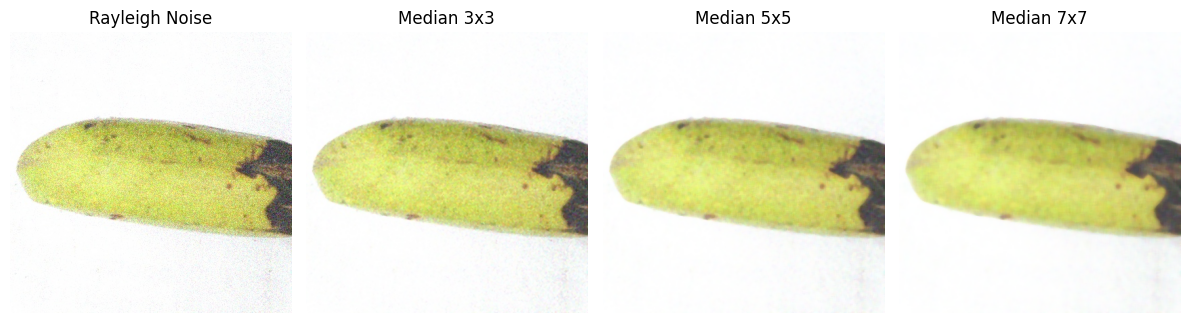

Median Filter 3x3:  MSE = 1198.92, PSNR = 17.34 dB
Median Filter 5x5:  MSE = 1198.11, PSNR = 17.35 dB
Median Filter 7x7:  MSE = 1204.78, PSNR = 17.32 dB


In [ ]:
#Median Filter
rotten_rayleigh = '/content/drive/My Drive/PCD_Proyek/Model/test/rotten_rayleigh'
unrotten_rayleigh = '/content/drive/My Drive/PCD_Proyek/Model/test/unrotten_rayleigh'

file_name = 'rotten3.jpg'

file_path = os.path.join(rotten, file_name)
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

file_path_noise = os.path.join(rotten_rayleigh, file_name)
img_noise = cv2.imread(file_path_noise)
img_noise = cv2.cvtColor(img_noise, cv2.COLOR_BGR2RGB)

filtered_3 = cv2.medianBlur(img_noise, 3)
filtered_5 = cv2.medianBlur(img_noise, 5)
filtered_7 = cv2.medianBlur(img_noise, 7)

titles = ['Rayleigh Noise', 'Median 3x3', 'Median 5x5', 'Median 7x7']
images = [img_noise, filtered_3, filtered_5, filtered_7]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

def compare(original, processed):
    error = mse(original, processed)
    psnr_val = psnr(original, processed, data_range=255)
    return error, psnr_val

mse_3, psnr_3 = compare(img, filtered_3)
mse_5, psnr_5 = compare(img, filtered_5)
mse_7, psnr_7 = compare(img, filtered_7)

print("Median Filter 3x3:  MSE = {:.2f}, PSNR = {:.2f} dB".format(mse_3, psnr_3))
print("Median Filter 5x5:  MSE = {:.2f}, PSNR = {:.2f} dB".format(mse_5, psnr_5))
print("Median Filter 7x7:  MSE = {:.2f}, PSNR = {:.2f} dB".format(mse_7, psnr_7))

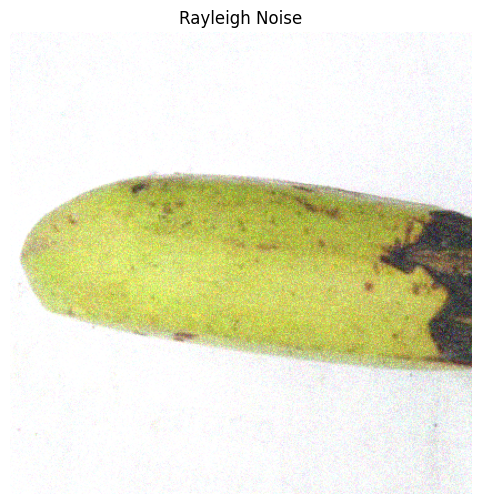

Median Filter 3x3:  MSE = 829.34, PSNR = 18.94 dB
Median Filter 5x5:  MSE = 826.97, PSNR = 18.96 dB
Median Filter 7x7:  MSE = 833.69, PSNR = 18.92 dB


In [ ]:
def add_rayleigh_noise(image, scale=30):
    rayleigh_noise = np.random.rayleigh(scale, image.shape)
    noisy = image + rayleigh_noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

# Define the missing show_image function
def show_image(image, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

file_name = 'rotten3.jpg'
file_path = os.path.join(rotten, file_name)
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

noisy_img = add_rayleigh_noise(img)
show_image(noisy_img, 'Rayleigh Noise')

filtered_3 = cv2.medianBlur(noisy_img, 3)
filtered_5 = cv2.medianBlur(noisy_img, 5)
filtered_7 = cv2.medianBlur(noisy_img, 7)

# filtered_3 = cv2.GaussianBlur(img, (3, 3), 0)
# filtered_5 = cv2.GaussianBlur(img, (5, 5), 0)
# filtered_7 = cv2.GaussianBlur(img, (7, 7), 0)

def compare(original, processed):
    error = mse(original, processed)
    psnr_val = psnr(original, processed, data_range=255)
    return error, psnr_val

mse_3, psnr_3 = compare(img, filtered_3)
mse_5, psnr_5 = compare(img, filtered_5)
mse_7, psnr_7 = compare(img, filtered_7)

print("Median Filter 3x3:  MSE = {:.2f}, PSNR = {:.2f} dB".format(mse_3, psnr_3))
print("Median Filter 5x5:  MSE = {:.2f}, PSNR = {:.2f} dB".format(mse_5, psnr_5))
print("Median Filter 7x7:  MSE = {:.2f}, PSNR = {:.2f} dB".format(mse_7, psnr_7))